## shock_cooling_curve: A tutorial

### Motivation: 

Early time data from core collapse events contain valuable information about their progenitor system. Some core collapse events produce double peaked light curves: details about the the location of shock breakout (we can think of this as the radius of the extended envelope of the progenitor), mass of the extended envelope, velocity of the radiative shock moving outwards, and the predicted time of explosion are all encoded in the analytic formalism that we build for the primary peak observed in these double peaked light curves.

Over the past decade, four popular analytic formalisms have been presented:
1. PIRO 2015: Model parameters = radius of envelope ($R_e$), mass of envelope ($M_e$), and offset time from explosion ($t_{offset}$)

2. PIRO 2020: Model parameters = radius of envelope ($R_e$), mass of envelope ($M_e$), velocity of shock ($v_e$) and offset time from explosion ($t_{offset}$)

3. Sapir & Waxman 2017 for blue supergiants [n = 3]: Model parameters = radius of envelope ($R_e$), mass of envelope ($M_e$), velocity of shock ($v_e$) and offset time from explosion ($t_{offset}$)

3. Sapir & Waxman 2017 for red supergiants [n = 1.5]: Model parameters = radius of envelope ($R_e$), mass of envelope ($M_e$), velocity of shock ($v_e$) and offset time from explosion ($t_{offset}$)

where n is the density slope parameter.

#### Shock cooling curve is a python package that facilitates using these models to analyze early time data from transients. Currently, two modelling techniques are available:
1. **Non linear least square optimization based curve fitting:** This fits several non linear curves returned by the model by a various combinations of values for the parameters of interest, and returns the parameters that minimize the square error between the non linear curve and observed magnitude data.

2. **Markov Chain Monte Carlo sampling:** This uses maximum likelihood estimation to return the choice of parameters that maxmize the likelihood of observing our data data.

In this problem, we are modelling lightcurves, so our x-data is the time from explosion and the y-data is the photometry in AB Magnitude.

In [45]:
# this cell ensures that any changes made to the script is reflected / reloaded each time we run a cell.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Required Imports

In [46]:
# The models are stored in shock_cooling_curve.models
from shock_cooling_curve.models import piro_2015, piro_2020, sw_bsg, sw_rsg

# Fitting module
from shock_cooling_curve.fitter import Fitter

# Plotting module
from shock_cooling_curve.plotter import Plotter

import matplotlib.pyplot as plt
import numpy as np


Initialize a model by calling one of the specified imports from `shock_cooling_curve.models`. This object inherits from `Supernova`, and will load in all required functionality to build an object that can parse through the provided photometry data and object configuration details.

Note: calling `func?` will display the required inputs and documentation for `func`.

### Creating a Supernova object

##### Config file

The first argument to initializing a `Supernova` object is `config_file` and is just the name of your configuration file. The supplied configuration file (in this example below it is called `config.ini` - note that only .ini files are accepted) should contain the following information:

1. **start_SN** = start time of the SN (MJD)
2. **end_SC** = end time of shock-cooling curve (MJD)
3. **ebv_host** = extinction of host
4. **ebv_mw** =  extinction of MW

5. **mcore** = mass of core (solar masses)
6. **bestEk3** = kinetic energy of ejecta (10^51 erg/s)

7. **dist_SN** = distance to SN (Mpc)

8. **FILENAME** =  photometry data file (csv)
9. **OBJNAME** = the name of the target object

A template of this the configuration file is available [here](https://github.com/padma18-vb/shock_cooling_curve/tree/main/templates). A template of the photometry data file can also be found in the same folder - the column names have to be the same as specified in the provided file and data for all columns is required.

##### Storage Path

The second argument `path_storage` specifies the path to where your config file (.ini), photometry data (.csv) and where you want any output files to be stored.

If you don't currently have any data, and would like to try using this package or help develop it, photometry data (and the configuration file) for SN2021gno is available under example_data in `shock_cooling_curve`'s repository [here](https://github.com/padma18-vb/shock_cooling_curve).

In [80]:
config_file_name = 'config.ini'
file_and_data_location = 'example_data'

# The statement below can be confusing. SW_RSG is a module under the package shock_cooling_curve.models -- it contains the SW_RSG class which inherits
# a Supernova object. So we're saying "from the module SW_BSG (which we've imported before), use the class SW_RSG. The other modules (SW_BSG, PIRO_2020 
# and PIRO_2015) follow the same structure."

test_model = sw_rsg.SW_RSG(config_file=config_file_name, path_storage=file_and_data_location)

`test_model` will contain all the information to process your photometry data. Under the supplied `path_to_storage`, you will find a new csv file called `reduced_data.csv`, which contains extincted magnitudes and only the data observed the specified time frame (in between `start_SN` and `end_SC`). Apart from this, test_model also has all the filter information for different surveys and corresponding bandpasses used to collect the photometry data.

In [95]:
# running this cell will show you more of the inner structure of a Supernova object and the information it holds.
# help(test_model)

# you can also call dir on test_model to see its attributes and methods

# dir(test_model)

#### Data Frames used

You can also view the final data being used for modeling using the following methods:

Below is the table containing all data points with reduced magnitudes:

In [96]:
test_model.extinction_applied_full_data

,MJD,MAG,MAGERR,FLT,Vega,RMAG,MJD_S
0,59293.54000,16.658862,0.041,W2,0.0,16.415724,0.84000
1,59293.88000,16.928862,0.042,W2,0.0,16.685724,1.18000
2,59294.44000,17.480862,0.044,W2,0.0,17.237724,1.74000
3,59295.51000,18.697862,0.058,W2,0.0,18.454724,2.81000
4,59296.60000,19.845862,0.112,W2,0.0,19.602724,3.90000
...,...,...,...,...,...,...,...
173,59380.28000,19.246068,0.068,i,0.0,19.188441,87.58000
174,59416.27000,19.860068,0.224,i,0.0,19.802441,123.57000
175,59571.33844,22.855068,0.361,i,0.0,22.797441,278.63844
176,59582.33904,22.726068,0.203,i,0.0,22.668441,289.63904


Below is the table containing data points collected when shock cooling emission was observed:

In [97]:
test_model.extinction_applied_data_during_shock_cooling

,MJD,MAG,MAGERR,FLT,Vega,RMAG,MJD_S
0,59293.540000,16.658862,0.041000,W2,0.0,16.415724,0.840000
1,59293.880000,16.928862,0.042000,W2,0.0,16.685724,1.180000
2,59294.440000,17.480862,0.044000,W2,0.0,17.237724,1.740000
3,59295.510000,18.697862,0.058000,W2,0.0,18.454724,2.810000
4,59296.600000,19.845862,0.112000,W2,0.0,19.602724,3.900000
14,59296.600000,20.159892,0.165000,M2,0.0,19.884784,3.900000
12,59294.440000,17.340892,0.045000,M2,0.0,17.065784,1.740000
13,59295.510000,18.447892,0.064000,M2,0.0,18.172784,2.810000
10,59293.550000,16.682892,0.045000,M2,0.0,16.407784,0.850000
11,59293.880000,16.858892,0.043000,M2,0.0,16.583784,1.180000


You can also obtain the filters used for this object (extracted from the photometry data you passed in as a csv file) and the filter information.

In [98]:
test_model.get_filts()

array(['W2', 'M2', 'W1', 'U', 'B', 'g', 'r', 'i'], dtype=object)

All filter information:

In [99]:
test_model.filter_info

,Bandpass,Effective Wavelength,AB - Vega,Color
W2,Swift_UVOT,1928.00,1.73,#C20078
M2,Swift_UVOT,2246.00,1.69,#00FFFF
W1,Swift_UVOT,2600.00,1.51,#380282
us,Swift_UVOT,3465.00,1.02,#7E1E9C
u,sdss,3546.00,0.91,#580F41
U,johnson,3571.00,0.79,#C79FEF
B,johnson,4344.00,-0.09,#7BC8F6
bs,Swift_UVOT,4346.25,-0.13,#0343DF
g,sdss,4670.00,-0.08,#15B01A
c,ATLAS,5183.87,0.00,#00FFFF


It's a good idea to check that the filters that you have provided in the photometry CSV file are correct according to the bandpass shown in the table above!

For example, if a datapoint is mapped to:
1. `us` --> synthetic photometry will be produced using **SWIFT UVOT** bandpass
2. `u` --> synthetic photometry will be produced using **sdss** bandpass
3. `U` --> synthetic photometry will be produced using **johnson** bandpass

The `pysynphot` python package is used to create these synthetic photometry values. More information about this package can be found [here](https://pysynphot.readthedocs.io/en/latest/bandpass.html).

### Fitter

In order to fit the specified model (PIRO_2015, PIRO_2020, SW_BSG or SW_RSG) to your data, you need to instantiate a `Fitter` object on your model. The only input for a `Fitter` object is your `Supernova` object.

Currently, `Fitter` has three main methods:
1. `nl_curve_fit()` --> returns the best-fit parameters and errors from applying `scipy.optimize.curvefit` to the data with the specified model. (nl = non-linear)

2. `minimize(...)` --> returns the best-fit parameters from applying `scipy.optimize.minimize` to the data with the specified model (if your model has a discontinuous luminosity function you can use this method to converge at the best-fit parameters).

3. `MCMC_fit(...)` --> returns the sampler chain returned by calling `sampler.run_mcmc(...)`.

In the following section we use `nl_curve_fit()` and `MCMC_fit(...)`.

In [100]:
# this cell will create a new instance of the Fitter object for our sn_obj - it stores all required information for applying fitting 
# methods to the SN_OBJ. It also carries reference to all information the sn_obj stores as we pass it into the Fitter.

fit_test_model = Fitter(sn_obj=test_model)

In [101]:
curve_fit_results = fit_test_model.nl_curve_fit(lower_bounds=None, upper_bounds=None)

No lower bounds were provided. Here are the lower bounds we used:
Lower bounds = [0.01, 0.01, 0.01, 0.001].
No upper bounds were provided. Here are the upper bounds we used:
Upper bounds = [10, 10, 10, 0.5].
initial_guess not provided. We use this initial guess:
Initial Guess = [2, 0.5, 2, 0.01].


In [102]:
# curve_fit_results is a tuple containing (fitted_params, errors = square root of the diagonal of the covariance matrix returned.)
# in order to access the covariance matrix you can ask for 
curve_fit_results

(array([0.28750879, 0.03802579, 0.72417145, 0.28502039]),
 array([0.02600571, 0.0019185 , 0.03501123, 0.02355537]))

These results are also stored in `Supernova` object:

In [103]:
cf_params, cf_errs = test_model.get_curvefit_values()
cf_params, cf_errs

({'re': 0.28750878849598227,
  'me': 0.038025787919288206,
  've': 0.7241714464391348,
  'off': 0.28502038826381015},
 {'re': 0.02600570504523337,
  'me': 0.0019184995797995763,
  've': 0.035011227723903984,
  'off': 0.023555365166502824})

In order to get a summary of the results as a DataFrame (or to simply print it out and read it interpretable units such solar masses etc), you can call the Fitter method shown below:

In [104]:
# options for model are "curvefit" and "MCMC"

results_df = fit_test_model.display_results(method = 'curvefit')
results_df

Model used: non linear least squared fitting
Sapir & Waxman (2017) [n = 1.5] model - SN2021gno:
re: 41.308733979307796 +/- 3.7364518743151396 R_sun
me: 0.038025787919288206 +/- 0.0019184995797995763 M_sun
ve: 0.7241714464391348 +/- 0.035011227723903984 1e9 cm/s
off: 0.28502038826381015 +/- 0.023555365166502824 days


,SW_RSG value,SW_RSG error
re (R_sun),41.308734,3.736452
me (M_sun),0.038026,0.001918
ve (1e9 cm/s),0.724171,0.035011
off (days),0.285020,0.023555


Below are some MCMC bounds we used for 2021gno - data available [here](https://github.com/padma18-vb/shock_cooling_curve/tree/main/example_data).

In [105]:
BSG_low = [0.01, 0.01, 0.01, 0.01]
BSG_high = [2, 2, 4, 0.5]

RSG_low = [0.01, 0.01, 0.01, 0.01]
RSG_high = [1, 2, 3, 0.8]

P15_low = [0.1, 0.01, 0.001]
P15_high = [200, 1, 1]

P20_low = [0.1, 0.01, 0.01, 0.001]
P20_high = [500, 1, 10, 0.2]

In [106]:
emcee_chain = fit_test_model.MCMC_fit(prior_low = RSG_low, 
                                     prior_high = RSG_high, 
                                     nwalkers = 50, 
                                     nsteps = 2000, 
                                     sigma = 2,
                                     use_initial_params = None,
                                     initialize_using_CF=True, 
                                     minimize_param_space=False)

Initial values were not provided. Using results from curve fitting as initial parameters.


100%|██████████| 2000/2000 [13:49<00:00,  2.41it/s]


In [108]:
emcee_chain.shape

(50, 2000, 4)

The chain returned from MCMC sampling will be store below in emcee_chain. The chain for each parameter will also be stored in the `Supernova` object as the attribute `MCMC_Sampler` - this a dictionary with the following structure: test_model.MCMC_sampler = {'param': array([sampler values])}.

In [109]:
test_model.MCMC_sampler


{'re': array([[0.28812838, 0.28836696, 0.28846457, ..., 0.27122555, 0.27122555,
         0.26556013],
        [0.287228  , 0.28710155, 0.28713453, ..., 0.28924653, 0.30153603,
         0.30153603],
        [0.28746684, 0.28746684, 0.28746684, ..., 0.29273893, 0.28906025,
         0.28454621],
        ...,
        [0.28749018, 0.28744444, 0.28722013, ..., 0.26253846, 0.26253846,
         0.26724245],
        [0.28706555, 0.28675347, 0.28586847, ..., 0.28850521, 0.28969456,
         0.28969456],
        [0.28725332, 0.28716964, 0.28688282, ..., 0.28023745, 0.27736111,
         0.28003117]]),
 'me': array([[0.03801026, 0.03801134, 0.0379946 , ..., 0.03821222, 0.03821222,
         0.03775952],
        [0.0379577 , 0.03792415, 0.03796258, ..., 0.03631767, 0.03623719,
         0.03623719],
        [0.03799311, 0.03799311, 0.03799311, ..., 0.03750559, 0.03724717,
         0.03717354],
        ...,
        [0.03805874, 0.03807352, 0.03814482, ..., 0.03748747, 0.03748747,
         0.0376872 ],


You can also save the sampler chain as it is output by MCMC_fit by calling `Fitter.save_chain_local(...)`.

In [110]:
# entering an empty string will just save the sampler chain in your current working directory.
fit_test_model.save_chain_local(local_path="", burnin=200)

MCMC sampler chains saved at the locations listed here: ['SN2021gno_SW_RSG_re_chain.csv', 'SN2021gno_SW_RSG_me_chain.csv', 'SN2021gno_SW_RSG_ve_chain.csv', 'SN2021gno_SW_RSG_off_chain.csv']


['SN2021gno_SW_RSG_re_chain.csv',
 'SN2021gno_SW_RSG_me_chain.csv',
 'SN2021gno_SW_RSG_ve_chain.csv',
 'SN2021gno_SW_RSG_off_chain.csv']

#### Loading in sampler data:

To reuse saved sampler data, you can load in the `.csv` files using `pandas` or some alternate file reading mechanism.

### Plotter

In order to make plots you can call the `Plotter` the same way you called the `Fitter` on your Supernova object.

In [111]:
plot_test_model = Plotter(test_model)

In [112]:
fit_test_model.set_MCMC_bounds_errs(sigma=1, burnin=0)

({'re': 0.2882348374346071,
  'me': 0.03807021581892176,
  've': 0.7227924303147722,
  'off': 0.284219838188121},
 {'re': [0.00434780841489435, 0.5721218664543198],
  'me': [0.00031903401119452723, 0.075821397626649],
  've': [0.0058815503229614485, 1.439703310306583],
  'off': [0.00411761147780737, 0.5643220648984346]})

Plot the MCMC Sampler chains:
If you wish you to save your plot, you can just call `plt.savefig` as usual.

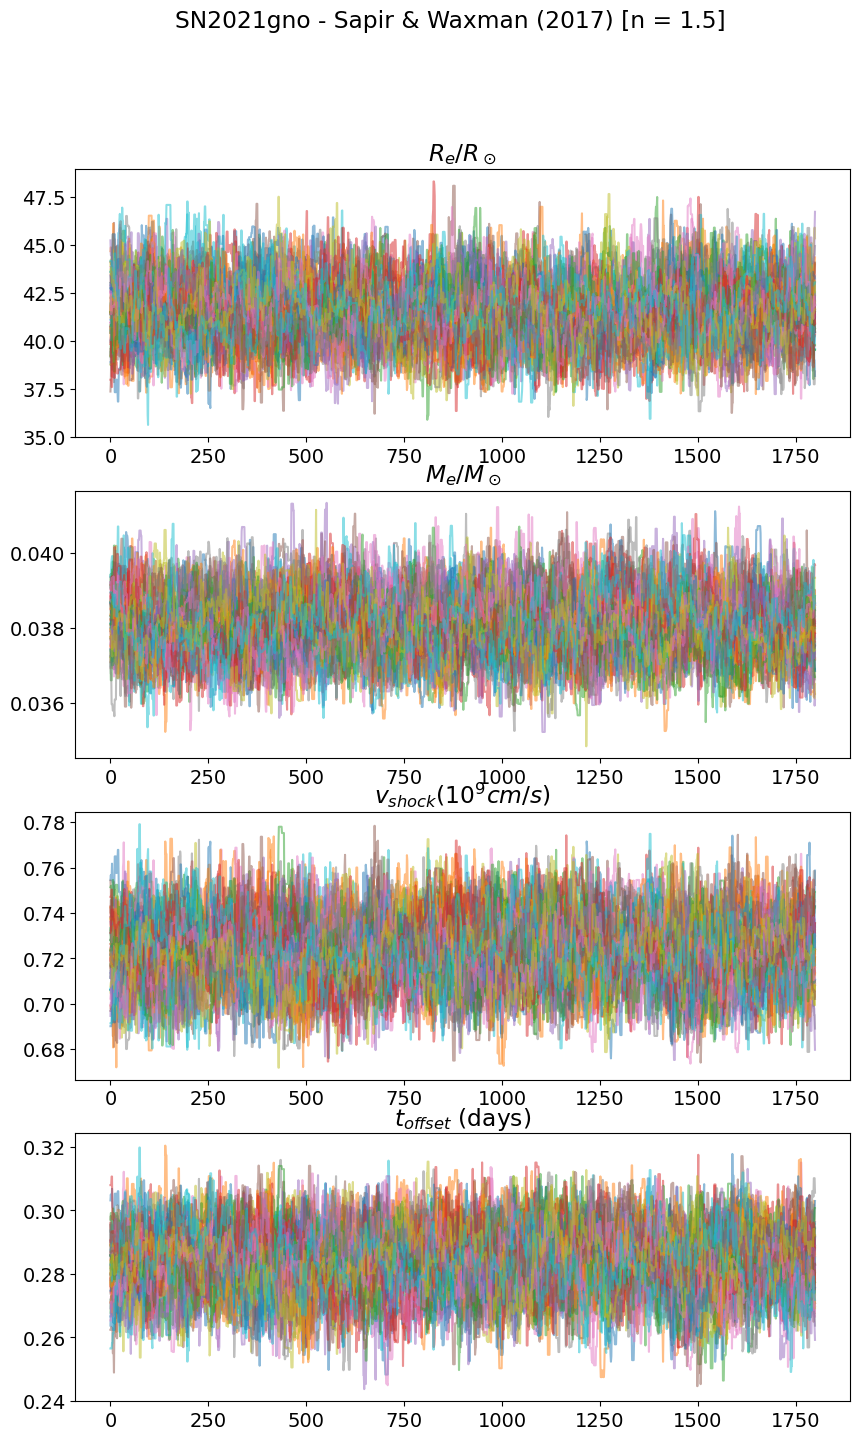

In [113]:
plot_test_model.MCMC_trace(burnin=200, color=True)
plt.savefig(f'{test_model.model_name}_walker_50_2000_pool.png', dpi = 200);

Plot the posterior corner plot for all the parameters:
The posteriors below are unscaled.

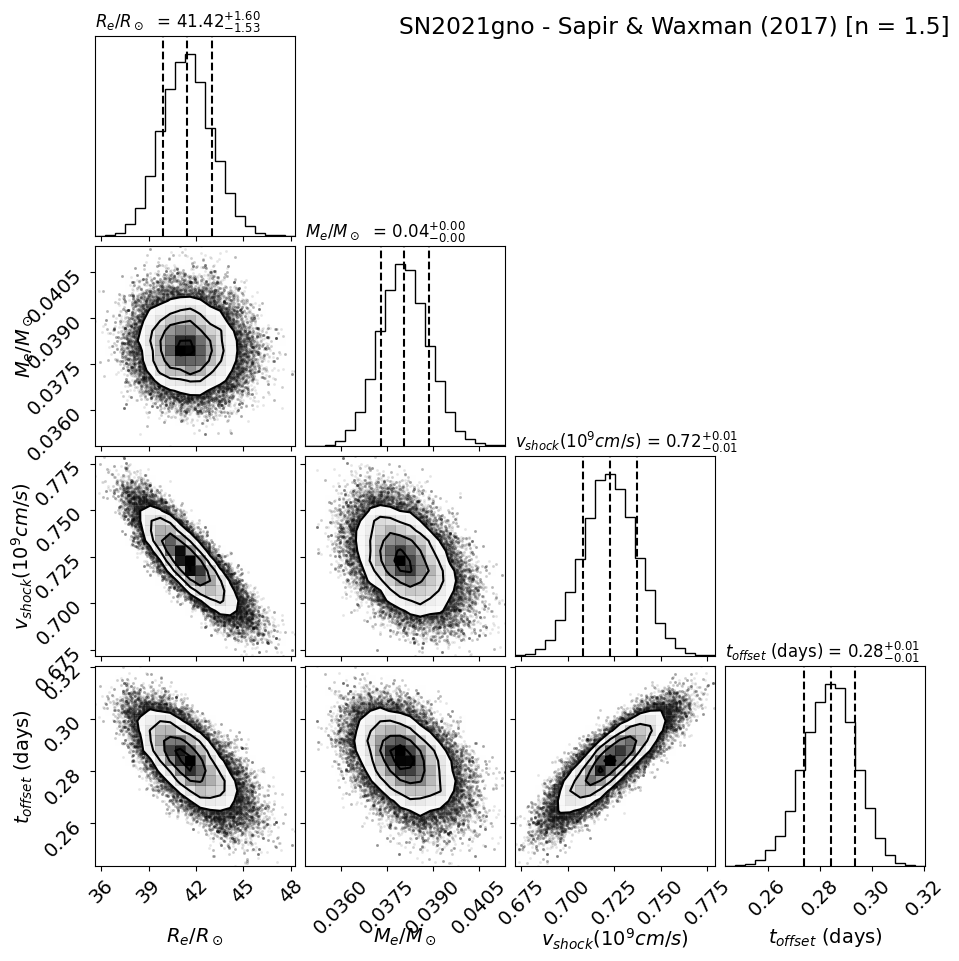

In [114]:
plot_test_model.MCMC_corner(burnin=200)
plt.savefig(f'{test_model.model_name}_corner_50_2000_pool.png', dpi = 200);

In [115]:
fit_test_model.set_MCMC_bounds_errs(sigma=1, burnin=200)

({'re': 0.28831697124180156,
  'me': 0.038064023349720574,
  've': 0.7227074933529898,
  'off': 0.28414101235294725},
 {'re': [0.004508781276612417, 0.5721251612069906],
  'me': [0.0003218826583548662, 0.07580616404108628],
  've': [0.005905355332431306, 1.4395096313735483],
  'off': [0.004211798610856243, 0.5640702260950383]})

In [116]:
params, errs = test_model.get_MCMC_values()
params, errs

({'re': 0.28831697124180156,
  'me': 0.038064023349720574,
  've': 0.7227074933529898,
  'off': 0.28414101235294725},
 {'re': [0.004508781276612417, 0.5721251612069906],
  'me': [0.0003218826583548662, 0.07580616404108628],
  've': [0.005905355332431306, 1.4395096313735483],
  'off': [0.004211798610856243, 0.5640702260950383]})

#### Plot the best fit curve against observed photometry by providing best fit parameters

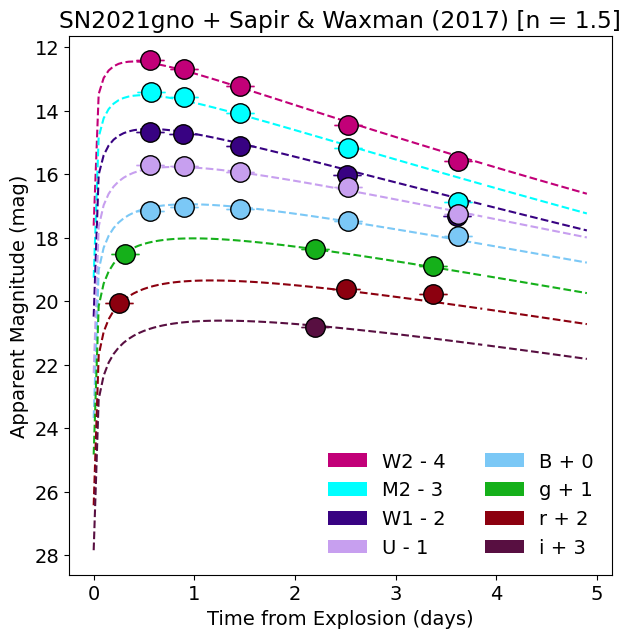

In [117]:
plot_test_model.plot_given_parameters(re=params['re'], me=params['me'], ve=params['ve'], of=params['off'], legend=True);
plt.savefig(f'{test_model.objname}_{test_model.model_name}_best_fit.png', dpi=200)


To obtain the goodness of fit estimate, you can use the following method:
Note: We define goodness of fit using a reduced chi-squared estimate defined as:
1. error = (synthetic photometry - observed photometry)
2. degrees of freedom = number of observed photometry data points - number of parameters of interest (3 or 4)
3. reduced chi-squared value = (error).(error)/dof

In [119]:
test_model.get_model_performance(params)

5.674383705344566